# Code from Blog 1 is included for continuity

## Part 1 - Retrieve the Data from the API

Now that we understand how the API request is constructed, let’s start working with our Python script. First, we need to load all of the necessary libraries.


In [1]:
import os
import pandas as pd
import requests

%matplotlib inline
from matplotlib import pyplot as plt

To communicate with the API and dynamically request data for different combinations of state FIPS codes, early years, and late years, we need to employ the Requests library. Requests is a library designed to allow users to send HTTP requests with Python. In the function below, we use the method .get to request data from API and load it into a Response object r. The Requests library includes a built in JSON decoder to read the JSON data that is returned and load it into a Pandas dataframe.

In [2]:
def create_dataframe(fips,early_year,late_year):
    """
    Submits request for data to the API and creates formatted pandas dataframe for use with clustering algorithms
    
    fips = string defining the 2-digit FIPS code for your state you of interest
    early_year = string defining the 1st date of change period (1996, 2001, 2006 or 2010)
    late_year = string defining the 2nd date of change period (1996, 2001, 2006 or 2010)
    """
    # Format inputs for url
    fips = "'{}'".format(fips)
    early_year = "'{}'".format(early_year)
    late_year = "'{}'".format(late_year)
    
    #API request for Land Cover data in JSON format
    url = "https://coast.noaa.gov/opendata/LandCover/api/v1/distributionOfChangeGainsLossesByLandcovers?$filter=startswith(geoId, {0}) and length(geoId) eq 5 and earlyYear eq {1} and lateYear eq {2}".format(fips, early_year, late_year)
    
    r = requests.get(url, headers={'Accept': 'application/json'})
    data = r.json()
    lca_df = pd.DataFrame(data['value'])
    
    # Set index to the FIPS code and drop Early and Late Year Fields
    lca_df_index = lca_df.set_index('geoId').drop(['earlyYear', 'lateYear'], axis=1)
    
    return lca_df_index

Now we will execute the function. The C-CAP Atlas has county level land cover change statistics organized by FIPS code and dates of change. C-CAP has mapped land cover for the years 1996, 2001, 2006 and 2010 using imagery acquired by the Landsat suite of satellites. This means we can look at changes in land cover that have occurred over multiple time series such as coarse intervals like 1996-2010 or we can look at finer scale changes over a 5 year period such as 2001-2006.  For this example, again we will select the state of Connecticut (FIPS code:9) and request land cover changes occurring from 2001-2010. 

In [3]:
CT_2001_2010 = create_dataframe('09',2001,2010)

Let’s confirm our new object contains the correct data using the method .head( ) 

In [4]:
CT_2001_2010.head()

,AgrAreaGain,AgrAreaLoss,BarAreaGain,BarAreaLoss,EmwAreaGain,EmwAreaLoss,ForAreaGain,ForAreaLoss,GrsAreaGain,GrsAreaLoss,...,LIDAreaGain,LIDAreaLoss,OSDAreaGain,OSDAreaLoss,SscbAreaGain,SscbAreaLoss,WdwAreaGain,WdwAreaLoss,WtrAreaGain,WtrAreaLoss
geoId,,,,,,,,,,,,,,,,,,,,,
09001,0.31,-1.64,0.43,-0.20,0.06,-0.16,0.67,-7.58,0.41,-0.30,...,4.33,-0.49,3.61,-1.77,0.49,-0.86,0.05,-0.36,0.05,-0.20
09003,0.71,-6.39,0.48,-0.19,0.14,-0.19,0.23,-10.56,1.06,-0.17,...,6.25,-0.45,6.91,-1.83,0.95,-1.95,0.08,-0.81,0.06,-0.26
09005,0.60,-1.03,0.31,-0.06,0.29,-0.10,0.20,-3.89,1.36,-0.22,...,0.77,-0.06,0.97,-0.20,0.84,-0.36,0.13,-0.22,0.12,-0.28
09007,0.30,-0.92,0.30,-0.09,0.12,-0.09,0.11,-4.09,0.24,-0.16,...,1.72,-0.11,1.37,-0.37,0.69,-0.47,0.05,-0.32,0.08,-0.15
09009,0.36,-1.92,0.49,-0.27,0.38,-0.13,0.20,-8.45,0.75,-0.59,...,4.05,-0.43,3.93,-1.55,0.71,-1.01,0.06,-0.42,0.15,-0.48


We can also get a list of the column names by using the following code

In [6]:
list(CT_2001_2010.columns.values)

['AgrAreaGain',
 'AgrAreaLoss',
 'BarAreaGain',
 'BarAreaLoss',
 'EmwAreaGain',
 'EmwAreaLoss',
 'ForAreaGain',
 'ForAreaLoss',
 'GrsAreaGain',
 'GrsAreaLoss',
 'HIDAreaGain',
 'HIDAreaLoss',
 'LIDAreaGain',
 'LIDAreaLoss',
 'OSDAreaGain',
 'OSDAreaLoss',
 'SscbAreaGain',
 'SscbAreaLoss',
 'WdwAreaGain',
 'WdwAreaLoss',
 'WtrAreaGain',
 'WtrAreaLoss']

# Part 2: Cleaning the Data

The objective of this blog post is to introduce some ways we can use the Pandas and GeoPandas libraries to prepare the data we retrieved from the Land Cover Atlas API and get it ready for exploratory analysis with unsupervised machine learning algorithms.  Additionally, we will acquire spatial data from the U.S. Census to be enable us to visualize the results.  To get started, let's import the required libraries

In [5]:
import os
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import io

%matplotlib inline
from matplotlib import pyplot as plt

Once we have loaded all of the necessary libraries,  we are going to need a shapefile representing the county boundaries for the entire U.S. Fortunately, we can easily download a TIGER/Line shapefile from our buddies at the U.S. Census Bureau.  We want to incorporate this data set into our project for 2 purposes:

1. Add county names to our Land Cover change DataFrame
2. Visualize the results of our exploratory analysis spatially

We will talk more about visualization in the next blog post. In the meantime, we can use the function below to download the TIGER/Line shapefile from Census using Requests, unzip it using the Zipfile library and import the shapefile into a GeoPandas GeoDataFrame. 

In [6]:
def download_shapefile(url, directory):
    """
    Download a shapefile in .zip format from a ftp site. Unzips shapefile and 
    loads it into a GeoPandas GeoDataFrame
    """          
    print('Downloading shapefile...')
        
    # Split on the URL on rightmost / and take everything on the right side of that
    # Replace .zip file extension with .shp
    shapefile = url.rsplit('/', 1)[-1].replace(".zip",".shp")
    
    r = requests.get(url)
    # Keep contents of the response object as bytes in an in-memory buffer using IO
    zipfile.ZipFile(io.BytesIO(r.content)).extractall(directory)
            
    # Read the shapefile into GeoPandas GeoDataframe   
    nation = gpd.read_file(os.path.join(directory,shapefile))
    
    return nation

Execute the function, downloading the data to the directory of your choice.

In [7]:
url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
us_counties = download_shapefile(url,"C:\\Projects\\Cluster") # Be sure to rename the directory

## Working with GeoPandas Dataframes

GeoPandas is an excellent open source library which facilitates working with spatial data in Python. It does this by leveraging the capabilities of the Pandas and Shapely libraries.  Since we have access to all of the operations available in Pandas, let's go ahead and inspect the attributes of our GeoPandas GeoDataFrame using the .info( ) method. This will provide us with a summary of the GeoDataFrame with information such as column data types and non-null values.

In [8]:
us_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 18 columns):
STATEFP     3233 non-null object
COUNTYFP    3233 non-null object
COUNTYNS    3233 non-null object
GEOID       3233 non-null object
NAME        3233 non-null object
NAMELSAD    3233 non-null object
LSAD        3233 non-null object
CLASSFP     3233 non-null object
MTFCC       3233 non-null object
CSAFP       1231 non-null object
CBSAFP      1899 non-null object
METDIVFP    113 non-null object
FUNCSTAT    3233 non-null object
ALAND       3233 non-null int64
AWATER      3233 non-null int64
INTPTLAT    3233 non-null object
INTPTLON    3233 non-null object
geometry    3233 non-null object
dtypes: int64(2), object(16)
memory usage: 454.7+ KB


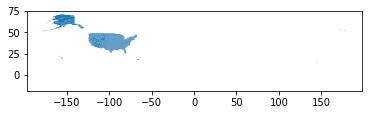

In [19]:
us_counties.plot()

I'll admit it's not the most visually appealing map but this provides us with a quick way to verify the geography is correct. 

Now that we have created a GeoPandas Dataframe, let's leverage some more of those tools available in the Pandas library. Let’s create a new GeoDataFrame that consists of a single coastal state. This can be performed using the .loc method which allows us to access groups of rows and columns. Here we will make our selection based on a state’s FIPS codes to make a new GeoDataFrame.

Now that we have made our selection, let's do some cleaning. First things first. Let's eliminate some redundancy. You may have noticed when inspecting the attributes of the GeoDataFrame that there are 2 columns containing county names, NAME and NAMELSAD. Let's use the .drop() method to remove the column called NAME. We also will use the .rename method to rename the GEOID and NAMELSAD columns. Renaming GEOID to geoId is required to enable joining with the land cover data we retrieved from the API. To reduce the lines of code and number of variables required, the methods are chained together on one line. This is a great feature within Python but be careful not to abuse it! See the function below.  

In [9]:
def select_state(fips, nation):
    """
    Creates new GeoDataFrame based on FIPS code
    
    fips:the 2-digit FIPS code for your state you of interest
    nation: GeoDataFrame of census counties
    """
      
    counties = nation.loc[nation['STATEFP'] == '{0}'.format(fips)].squeeze()
    counties = counties.drop(columns=['NAME']).rename(columns={'GEOID': 'geoId','NAMELSAD': 'name'})
        
    #return counties
    return counties

Now, we will execute the function. For this example we will select the state of Connecticut (FIPS code: 09). Make sure the FIPS code is provided as a String!  

In [10]:
counties_gdf = select_state('09', us_counties)

Just to confirm our new object contains changes we made to the columns, let’s use the Pandas method .columns to view a full list of the labels.

In [11]:
counties_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'geoId', 'name', 'LSAD', 'CLASSFP',
       'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

It looks like the modifications are present. While we are at it. Let's use .plot( ) again to check our geography. If everything looks good, we are going to set the GeoDataFrame aside for use in the next blog post.

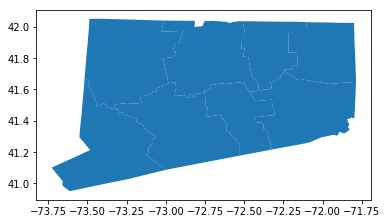

In [12]:
counties_gdf.plot()

You may have noticed earlier when you inspected the DataFrame of land cover change data that the table only includes FIPS codes. When it comes time to make visualizations of our analysis is may be helpful to be able use the actual county names as labels. To do this, let’s create another Pandas DataFrame with county names and FIPs codes for our state of interest using the GeoPandas GeoDataFrame we created in the last section.  We will accomplish this by using square brackets [ ] to select specific columns (geoId & name) from the GeoDataFrame. To make the upcoming merge process work, we'll need to set the resulting DataFrame's index to the FIPS code ('geoId') using the .set_index( ) method.

In [13]:
def create_fips_table(dataframe):
    """
    Creates table of FIPS codes and county names for joining to Land Cover DataFrame
    
    dataframe: Geopandas dataframe of State of interest
    
    """
    
    county_attributes = pd.DataFrame(dataframe)
    fips_names = county_attributes[['geoId','name']].set_index('geoId')
    
    return fips_names

Let's execute the function.  

In [14]:
fips_df = create_fips_table(counties_gdf)

Once again, let’s confirm our new object contains the correct data using the method .head( )  

In [15]:
fips_df.head()

,name
geoId,
09007,Middlesex County
09011,New London County
09009,New Haven County
09013,Tolland County
09003,Hartford County


In [16]:
def merge_dataframes(dataframe,fips_names_df):
    """
    Merges county names to land cover dataframe based on FIPS code
    
    dataframe: DataFrame with Land Cover change data
    fips_names_df: DataFrame with FIPS codes and County Names
    """
    fips_names_index_df = pd.merge(dataframe, fips_names_df,left_index=True,right_index=True).set_index('name')
        
    return fips_names_index_df

In the function below, we use the Pandas method .merge( ) to perform a database-style join of  the county FIPS and names DataFrame with LC Change Dataframe we created from the API. We also use the .set_index( ) method to set the names column as the index of the resulting DataFrame. 

In [19]:
CT_2001_2010_index = merge_dataframes(CT_2001_2010, fips_df)

Once again, let’s confirm our new object contains the correct data using the method .info( )  

In [20]:
CT_2001_2010_index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Fairfield County to Windham County
Data columns (total 22 columns):
AgrAreaGain     8 non-null float64
AgrAreaLoss     8 non-null float64
BarAreaGain     8 non-null float64
BarAreaLoss     8 non-null float64
EmwAreaGain     8 non-null float64
EmwAreaLoss     8 non-null float64
ForAreaGain     8 non-null float64
ForAreaLoss     8 non-null float64
GrsAreaGain     8 non-null float64
GrsAreaLoss     8 non-null float64
HIDAreaGain     8 non-null float64
HIDAreaLoss     8 non-null float64
LIDAreaGain     8 non-null float64
LIDAreaLoss     8 non-null float64
OSDAreaGain     8 non-null float64
OSDAreaLoss     8 non-null float64
SscbAreaGain    8 non-null float64
SscbAreaLoss    8 non-null float64
WdwAreaGain     8 non-null float64
WdwAreaLoss     8 non-null float64
WtrAreaGain     8 non-null float64
WtrAreaLoss     8 non-null float64
dtypes: float64(22)
memory usage: 1.4+ KB


## Conclusion

And there you have it. You have officially used the Pandas library to clean data sets you retrieved from an API and downloaded from a website. You have sliced columns, dropped columns, renamed columns, set indexes and merged DataFrames. Really, that is just a small sample of what you can do in Pandas. Next, we get down to the nitty gritty and explore our data using unsupervised machine learning. See you soon!
    
Chris
